In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn_extra.cluster import KMedoids  # PAM


import warnings

warnings.filterwarnings("ignore")

encoder = OrdinalEncoder()
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


sns.set(font_scale=1.5)
sns.set_style("darkgrid")
sns.set_palette("pastel")

In [56]:
plt.rcParams["figure.figsize"] = [15, 7]

In [57]:
data = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

<center>


**Table 1: Customer Churn Dataset** 

| Feature          | Description                                           | Type                  |
|------------------|-------------------------------------------------------|-----------------------|
| customerID       | Customer ID, a unique identifier                       | Categorical           |
| gender           | Whether the customer is male or female                 | Categorical           |
| SeniorCitizen    | Whether the customer is a senior citizen (1 or 0)      | Dichotomous categorical |
| Partner          | Whether the customer has a partner (Yes or No)         | Categorical           |
| Dependents       | Whether the customer has dependents (Yes or No)        | Categorical           |
| tenure           | Number of months the customer has stayed               | Integer-valued         |
| PhoneService     | Whether the customer has phone service (Yes or No)      | Categorical           |
| MultipleLines    | Whether the customer has multiple lines                | Categorical           |
| InternetService  | Customer’s internet service provider                   | Categorical           |
| OnlineSecurity   | Whether the customer has online security               | Categorical           |
| OnlineBackup     | Whether the customer has online backup                 | Categorical           |
| DeviceProtection | Whether the customer has device protection             | Categorical           |
| TechSupport      | Whether the customer has tech support                  | Categorical           |
| StreamingTV      | Whether the customer has streaming TV                  | Categorical           |
| StreamingMovies  | Whether the customer has streaming movies              | Categorical           |
| Contract         | The contract term of the customer                      | Categorical           |
| PaperlessBilling | Whether the customer has paperless billing             | Categorical           |
| PaymentMethod    | The customer’s payment method                          | Categorical           |
| MonthlyCharges   | The amount charged to the customer monthly             | Continuous            |
| TotalCharges     | The total amount charged to the customer               | Continuous            |
| Churn            | Whether the customer churned (Yes or No)               | Categorical           |

</center>

In [58]:
data = data.drop(columns="customerID")

In [59]:
data.drop_duplicates(inplace=True)

In [60]:
data.drop("TotalCharges", axis=1, inplace=True)

In [61]:
nominal_features = ("PaperlessBilling", "Dependents", "Partner", "Churn")
for feature in nominal_features:
    data[feature] = data[feature].map({"Yes": 1, "No": 0})

In [62]:
data[["tenure", "MonthlyCharges"]].describe().to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &       tenure &  MonthlyCharges \\\\\n\\midrule\ncount &  7021.000000 &     7021.000000 \\\\\nmean  &    32.469449 &       64.851894 \\\\\nstd   &    24.534965 &       30.069001 \\\\\nmin   &     0.000000 &       18.250000 \\\\\n25\\%   &     9.000000 &       35.750000 \\\\\n50\\%   &    29.000000 &       70.400000 \\\\\n75\\%   &    55.000000 &       89.900000 \\\\\nmax   &    72.000000 &      118.750000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [63]:
df_cluster = data.copy()

In [64]:
df_cluster.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,1,0,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,0
1,Male,0,0,0,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,0
2,Male,0,0,0,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,1
3,Male,0,0,0,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,0
4,Female,0,0,0,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,1


In [65]:
scaler = StandardScaler()
df_cluster[["tenure", "MonthlyCharges"]] = scaler.fit_transform(
    df_cluster[["tenure", "MonthlyCharges"]]
)

df_cluster[
    df_cluster.columns[~df_cluster.columns.isin(["tenure", "MonthlyCharges"])]
] = encoder.fit_transform(
    df_cluster[
        df_cluster.columns[~df_cluster.columns.isin(["tenure", "MonthlyCharges"])]
    ]
)

In [66]:
# take data without churn columns:
df_cluster = df_cluster[df_cluster.columns[:-1]]

In [67]:
df_cluster

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,0.0,0.0,1.0,0.0,-1.282728,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,-1.164135
1,1.0,0.0,0.0,0.0,0.062387,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,-0.262811
2,1.0,0.0,0.0,0.0,-1.241967,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,-0.365914
3,1.0,0.0,0.0,0.0,0.510759,0.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,-0.750058
4,0.0,0.0,0.0,0.0,-1.241967,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.194503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,1.0,1.0,-0.345224,1.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0,0.663458
7039,0.0,0.0,1.0,1.0,1.611307,1.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,1.0,1.0,1.275428
7040,0.0,0.0,1.0,1.0,-0.875118,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,-1.172450
7041,1.0,1.0,1.0,0.0,-1.160445,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.317562


## Wybór rozmiaru klastrów

### Metoda Silhouette
- Wykorzystuje miarę silhouette, która ocenia, jak dobrze punkt danych pasuje do swojego klastra w porównaniu z sąsiednimi klastrami.
- Dla różnych liczby klastrów oblicza się średnią wartość silhouette.
- Wybiera się liczbę klastrów, dla której wartość silhouette jest maksymalna.

In [68]:
def optimise_k_means_silhouette_score(data, max_k):
    means = []
    silhouette = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        silhouette.append(silhouette_score(data, kmeans.labels_))

    plt.plot(means, silhouette, "o-", color="black")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Average Silhouette Score")
    plt.grid(True)
    plt.savefig("images_clustering/silhouette_score.pdf")
    plt.show()

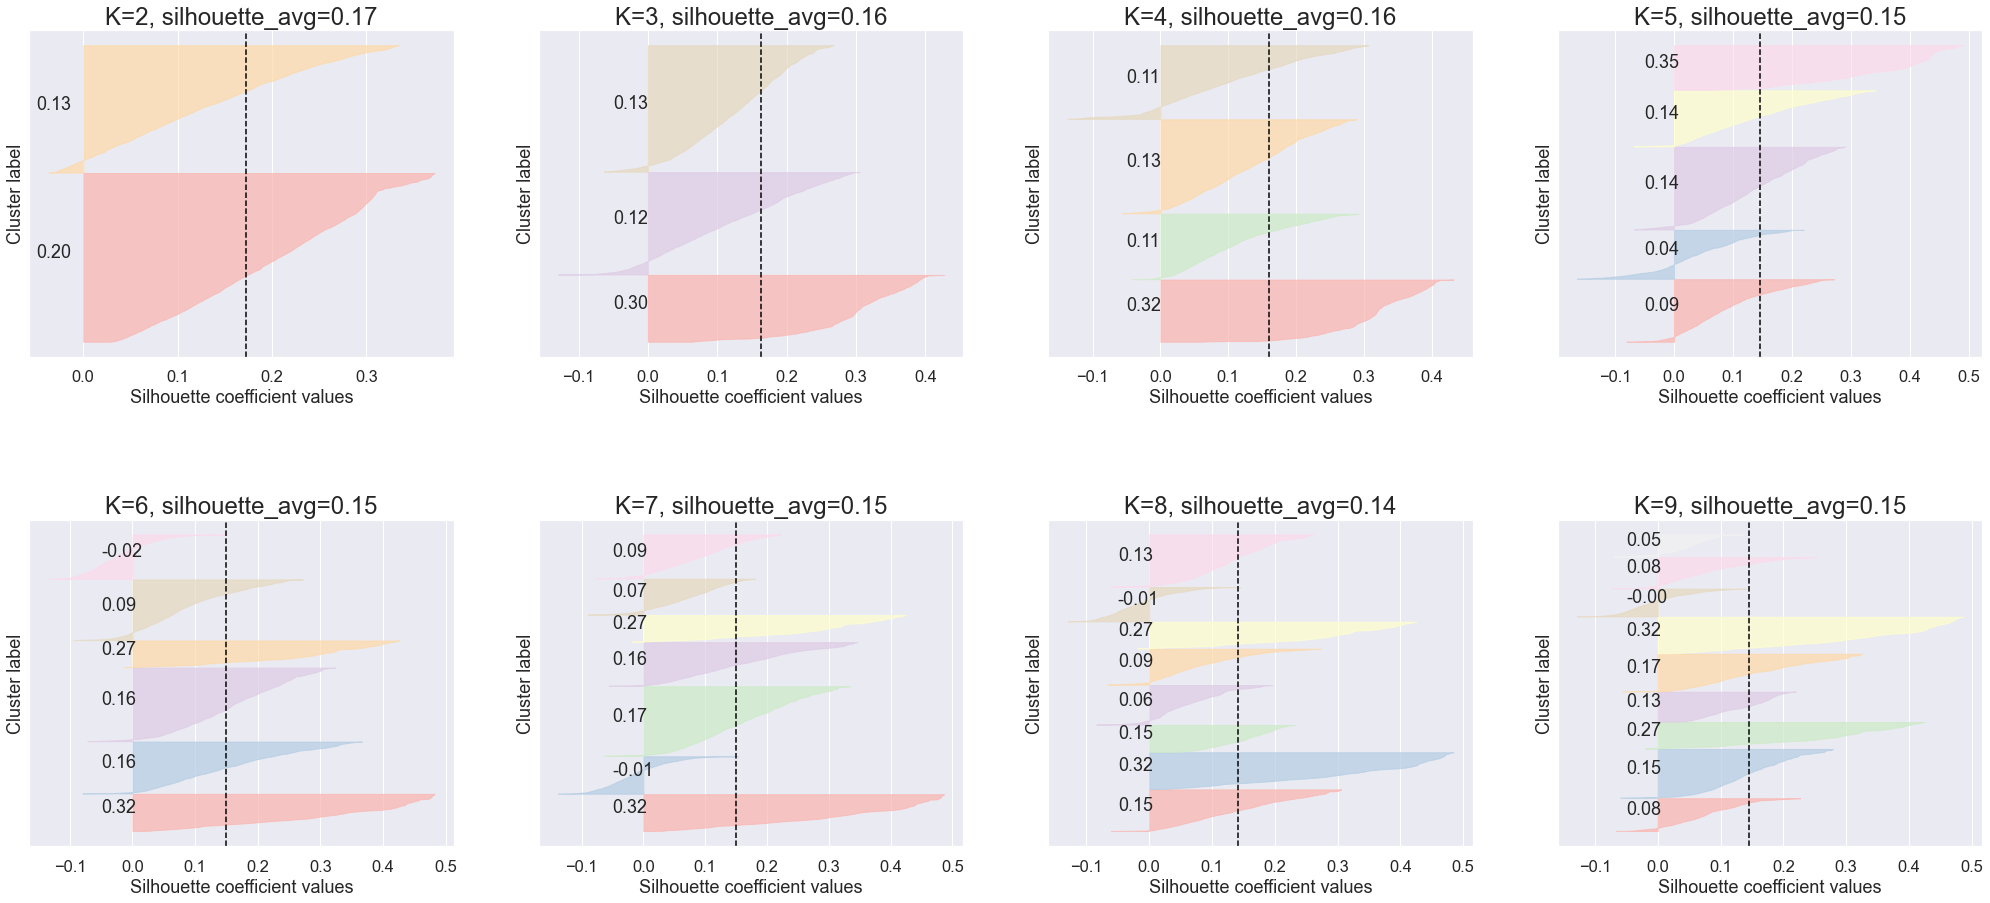

In [69]:
k_values = range(2, 10)
pastel_cmap = plt.get_cmap("Pastel1")
fig, axs = plt.subplots(2, 4, figsize=(35, 15))
fig.subplots_adjust(hspace=0.5)
axs = axs.flatten()
table = []
for idx, k in enumerate(k_values):
    plt.sca(axs[idx])
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_cluster)
    silhouette_avg = silhouette_score(df_cluster, cluster_labels)
    sample_silhouette_values = silhouette_samples(df_cluster, cluster_labels)
    y_lower = 10
    table.append(silhouette_avg)

    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = pastel_cmap(float(i) / k)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        plt.text(
            -0.05,
            y_lower + 0.5 * size_cluster_i,
            f"{ith_cluster_silhouette_values.mean():.2f}",
        )  # Write silhouette coefficient value
        y_lower = y_upper + 10
    plt.title(f"K={k}, silhouette_avg={np.round(silhouette_avg, 2)}", fontsize=24)
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_avg, color="black", linestyle="--")
    plt.yticks([])
    plt.savefig("images_clustering/silhouette_scores.pdf")

In [70]:
table = pd.DataFrame(table, index=k_values, columns=["Silhouette Score"])

In [71]:
table

,Silhouette Score
2,0.172704
3,0.162883
4,0.160684
5,0.145422
6,0.148794
7,0.149995
8,0.140663
9,0.145346


In [72]:
plt.rcParams["figure.figsize"] = [15, 7]

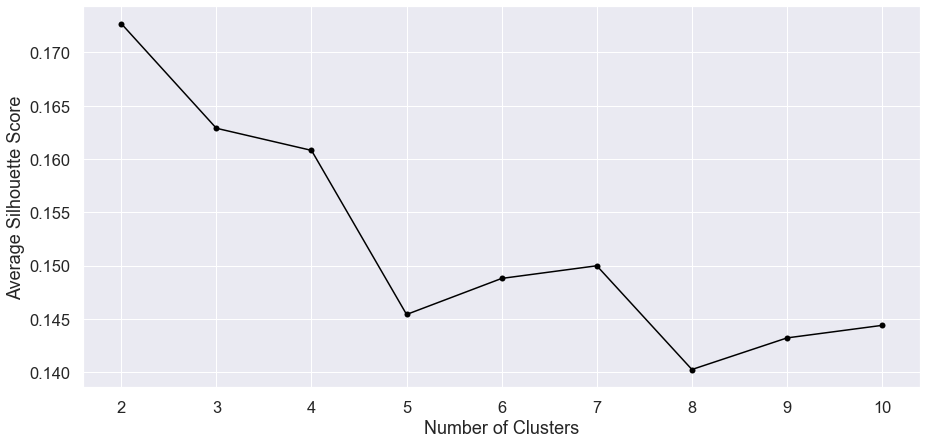

In [73]:
optimise_k_means_silhouette_score(df_cluster, 10)

### Metoda Daviesa-Bouldina

Kluczowym celem tej metody jest minimalizacja stosunku między średnimi odległościami wewnątrz klastrów a odległościami między klastrami dla różnych liczby klastrów.
W praktyce, optymalna liczba klastrów to taka, dla której ten stosunek jest minimalny. Oznacza to, że klastry są zarówno kompaktowe, jak i dobrze odseparowane od siebie.
Podsumowując, Metoda Daviesa-Bouldina stara się znaleźć taką liczbę klastrów, dla której klastry są jednocześnie jak najbardziej zwarte wewnętrznie i jak najbardziej odległe od siebie nawzajem. Minimalizacja stosunku między tymi dwiema miarami sugeruje optymalną strukturę klastrów w analizowanym zbiorze danych.

In [74]:
def optimise_k_means_davies_bouldin(data, max_k):
    davies_bouldin_scores = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        db_index = davies_bouldin_score(data, kmeans.labels_)
        davies_bouldin_scores.append(db_index)

    plt.plot(range(2, max_k + 1), davies_bouldin_scores, "o-", color="black")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Davies-Bouldin Index")
    plt.grid(True)
    plt.savefig("images_clustering/davies_bouldin.pdf")
    plt.show()

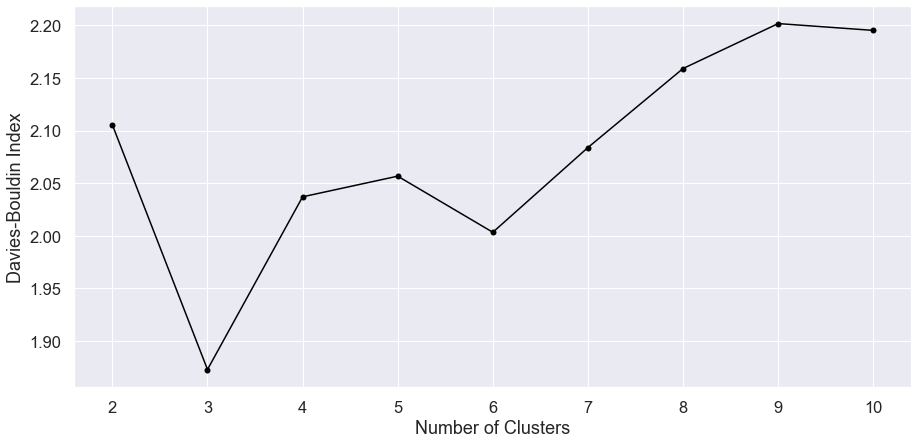

In [75]:
optimise_k_means_davies_bouldin(df_cluster, 10)

Wybierz punkt łokcia lub minimalnej wartości:

Podobnie jak w przypadku metody łokcia, możesz przyjąć punkt, w którym wartość Daviesa-Bouldina zaczyna się stabilizować lub osiąga minimum, jako optymalną liczbę klastrów.
Możesz również zbadać obszary wokół potencjalnych punktów optymalnych, aby potwierdzić stabilność wyboru.

In [76]:
def optimise_k_means_calinski_harabasz(df_cluster):
    ch_index_values = []
    k_values = range(2, 11)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(df_cluster)
        ch_index = calinski_harabasz_score(df_cluster, cluster_labels)
        ch_index_values.append(ch_index)
        print(f"For n_clusters = {k}, Calinski-Harabasz Index is {ch_index}")

    best_k = k_values[np.argmax(ch_index_values)]
    print(f"The best number of clusters is {best_k} based on Calinski-Harabasz Index.")

    plt.plot(k_values, ch_index_values, "o-", color="black")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Calinski-Harabasz Index")
    plt.grid(True)
    plt.savefig("images_clustering/calinski_harabasz.pdf")
    plt.show()

    return best_k

For n_clusters = 2, Calinski-Harabasz Index is 1544.164818260861
For n_clusters = 3, Calinski-Harabasz Index is 1298.52839662311
For n_clusters = 4, Calinski-Harabasz Index is 1126.7749470674717
For n_clusters = 5, Calinski-Harabasz Index is 986.8774300738785
For n_clusters = 6, Calinski-Harabasz Index is 900.5190762068269
For n_clusters = 7, Calinski-Harabasz Index is 824.3085042501968
For n_clusters = 8, Calinski-Harabasz Index is 758.8224448283354
For n_clusters = 9, Calinski-Harabasz Index is 706.843424024658
For n_clusters = 10, Calinski-Harabasz Index is 657.6898493386204
The best number of clusters is 2 based on Calinski-Harabasz Index.


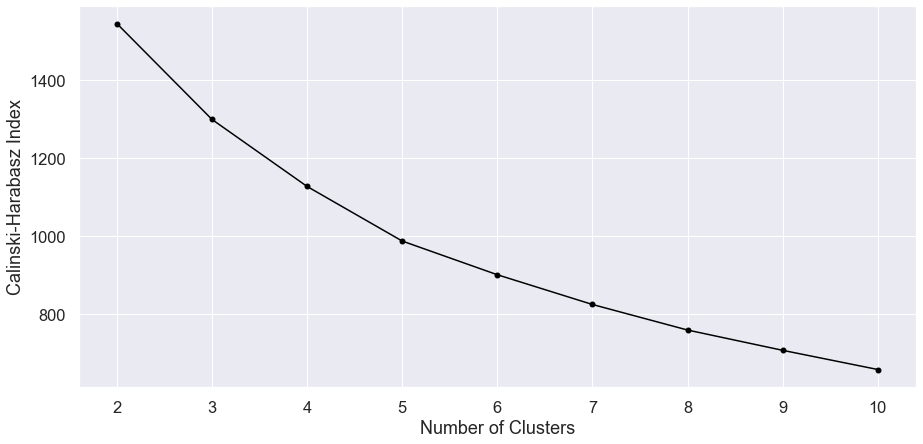

2

In [77]:
optimise_k_means_calinski_harabasz(df_cluster)

### Analiza Hierarchiczna:

- jak często klastry dzielą się na różnych poziomach drzewa.
- Kiedy kolejne podziały nie przynoszą znaczącej korzyści, możesz uznać tę liczbę klastrów za optymalną.

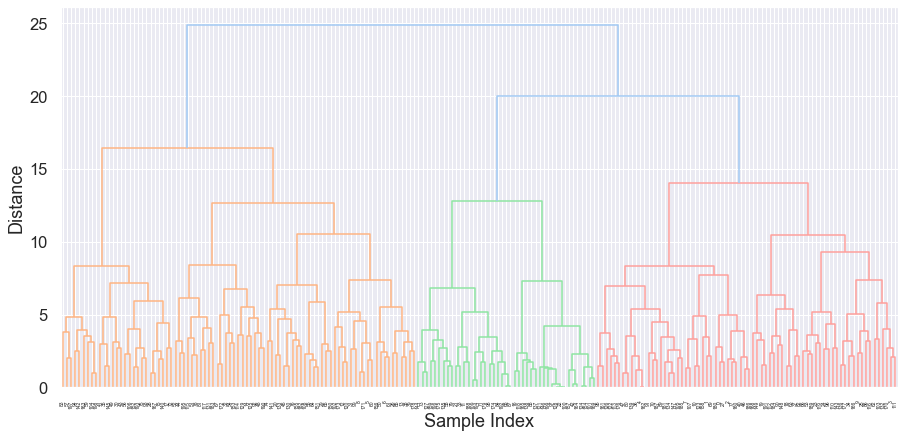

In [78]:
linkage_matrix = linkage(
    df_cluster[:200], method="ward"
)  # dałam okrojony zbiór, bo inaczej za długo liczyło
dendrogram(linkage_matrix)
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.savefig("images_clustering/dendrogram.pdf")
plt.show()

## Wizualizacja

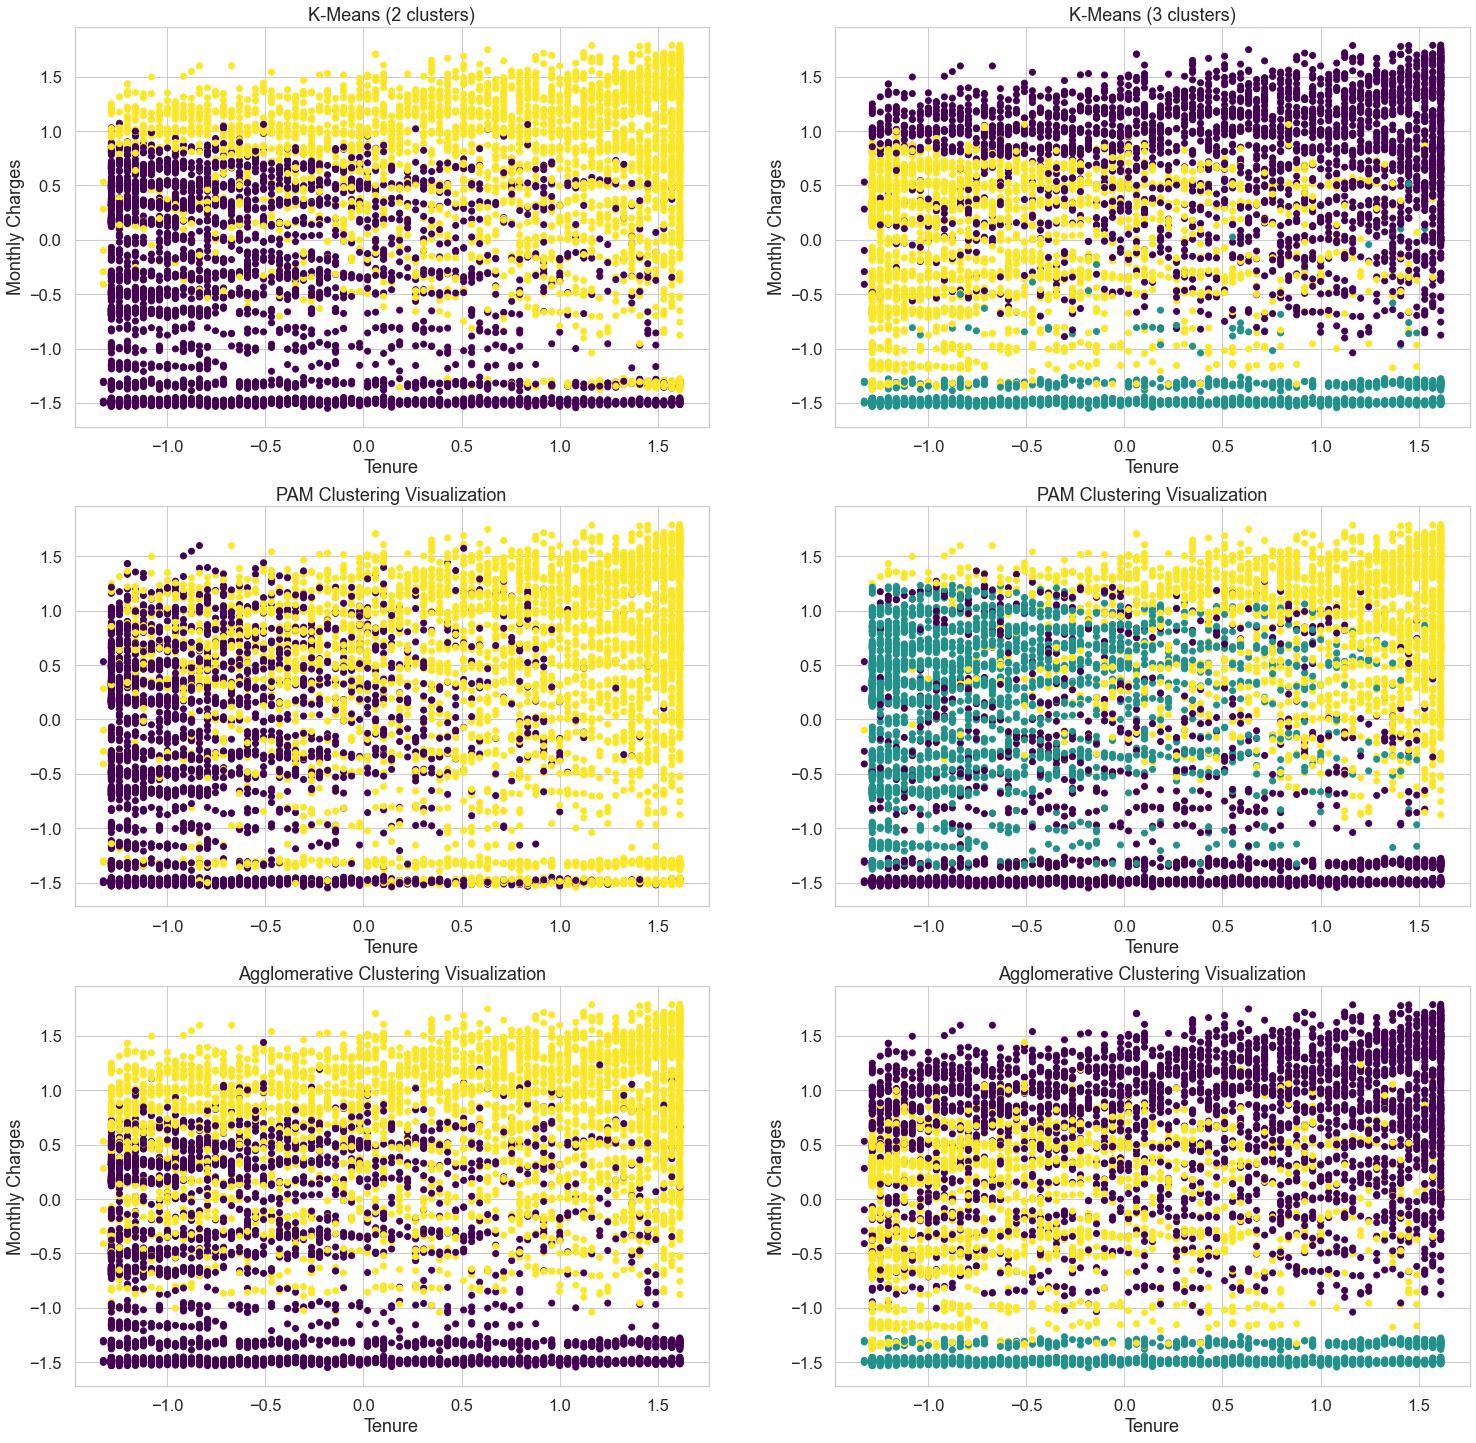

In [136]:
fig, axs = plt.subplots(3, 2, figsize=(25, 25))
# change fontsize for titles
plt.rcParams.update({"font.size": 30})
# K-Means with 2 clusters
kmeans = KMeans(n_clusters=2)

kmeans.fit(df_cluster)


axs[0, 0].scatter(
    df_cluster["tenure"], df_cluster["MonthlyCharges"], c=kmeans.labels_, cmap="viridis"
)



axs[0, 0].set_xlabel("Tenure")
axs[0, 0].set_ylabel("Monthly Charges")
axs[0, 0].set_title("K-Means (2 clusters)")

# K-Means with 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_cluster)
axs[0, 1].scatter(
    df_cluster["tenure"], df_cluster["MonthlyCharges"], c=kmeans.labels_, cmap="viridis"
)
axs[0, 1].set_xlabel("Tenure")
axs[0, 1].set_ylabel("Monthly Charges")
axs[0, 1].set_title("K-Means (3 clusters)")

# PAM with 2 clusters
PAM = KMedoids(n_clusters=2)
PAM.fit(df_cluster)
axs[1, 0].scatter(
    df_cluster["tenure"], df_cluster["MonthlyCharges"], c=PAM.labels_, cmap="viridis"
)

axs[1, 0].set_xlabel("Tenure")
axs[1, 0].set_label("Monthly Charges")
axs[1, 0].set_title("PAM Clustering Visualization")

# PAM with 3 clusters
PAM = KMedoids(n_clusters=3)
PAM.fit(df_cluster)
axs[1, 1].scatter(
    df_cluster["tenure"], df_cluster["MonthlyCharges"], c=PAM.labels_, cmap="viridis"
)

axs[1, 1].set_xlabel("Tenure")
axs[1, 1].set_label("Monthly Charges")
axs[1, 1].set_title("PAM Clustering Visualization")

# Agglomerative with 2 clusters
agg = AgglomerativeClustering(n_clusters=2)
agg.fit(df_cluster)
axs[2, 0].scatter(
    df_cluster["tenure"], df_cluster["MonthlyCharges"], c=agg.labels_, cmap="viridis"
)

axs[2, 0].set_xlabel("Tenure")
axs[2, 0].set_ylabel("Monthly Charges")
axs[2, 0].set_title("Agglomerative Clustering Visualization")

# Agglomerative with 3 clusters
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(df_cluster)
axs[2, 1].scatter(
    df_cluster["tenure"], df_cluster["MonthlyCharges"], c=agg.labels_, cmap="viridis"
)

axs[2, 1].set_xlabel("Tenure")
axs[2, 1].set_ylabel("Monthly Charges")
axs[2, 1].set_title("Agglomerative Clustering Visualization")

plt.savefig("images_clustering/clustering_visualization.pdf")

In [128]:
# Initialize an empty list to store cluster sizes
cluster_sizes = []

# K-Means with 2 clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_cluster)

# Append cluster sizes to the list
cluster_sizes.append(
    ("K-Means (2 clusters)", pd.Series(kmeans.labels_).value_counts().to_dict())
)

# K-Means with 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_cluster)
cluster_sizes.append(
    ("K-Means (3 clusters)", pd.Series(kmeans.labels_).value_counts().to_dict())
)

# PAM with 2 clusters
PAM = KMedoids(n_clusters=2)
PAM.fit(df_cluster)
cluster_sizes.append(
    ("PAM (2 clusters)", pd.Series(PAM.labels_).value_counts().to_dict())
)

# PAM with 3 clusters
PAM = KMedoids(n_clusters=3)
PAM.fit(df_cluster)
cluster_sizes.append(
    ("PAM (3 clusters)", pd.Series(PAM.labels_).value_counts().to_dict())
)

# Agglomerative with 2 clusters
agg = AgglomerativeClustering(n_clusters=2)
agg.fit(df_cluster)
cluster_sizes.append(
    ("Agglomerative (2 clusters)", pd.Series(agg.labels_).value_counts().to_dict())
)

# Agglomerative with 3 clusters
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(df_cluster)
cluster_sizes.append(
    ("Agglomerative (3 clusters)", pd.Series(agg.labels_).value_counts().to_dict())
)

# Print the list of cluster sizes
print("List of Cluster Sizes:")
for cluster_name, sizes_dict in cluster_sizes:
    print(f"{cluster_name}: {sizes_dict}")

List of Cluster Sizes:
K-Means (2 clusters): {1: 3970, 0: 3051}
K-Means (3 clusters): {0: 3011, 1: 2446, 2: 1564}
PAM (2 clusters): {1: 3710, 0: 3311}
PAM (3 clusters): {1: 2723, 0: 2175, 2: 2123}
Agglomerative (2 clusters): {0: 3645, 1: 3376}
Agglomerative (3 clusters): {0: 3376, 2: 2133, 1: 1512}


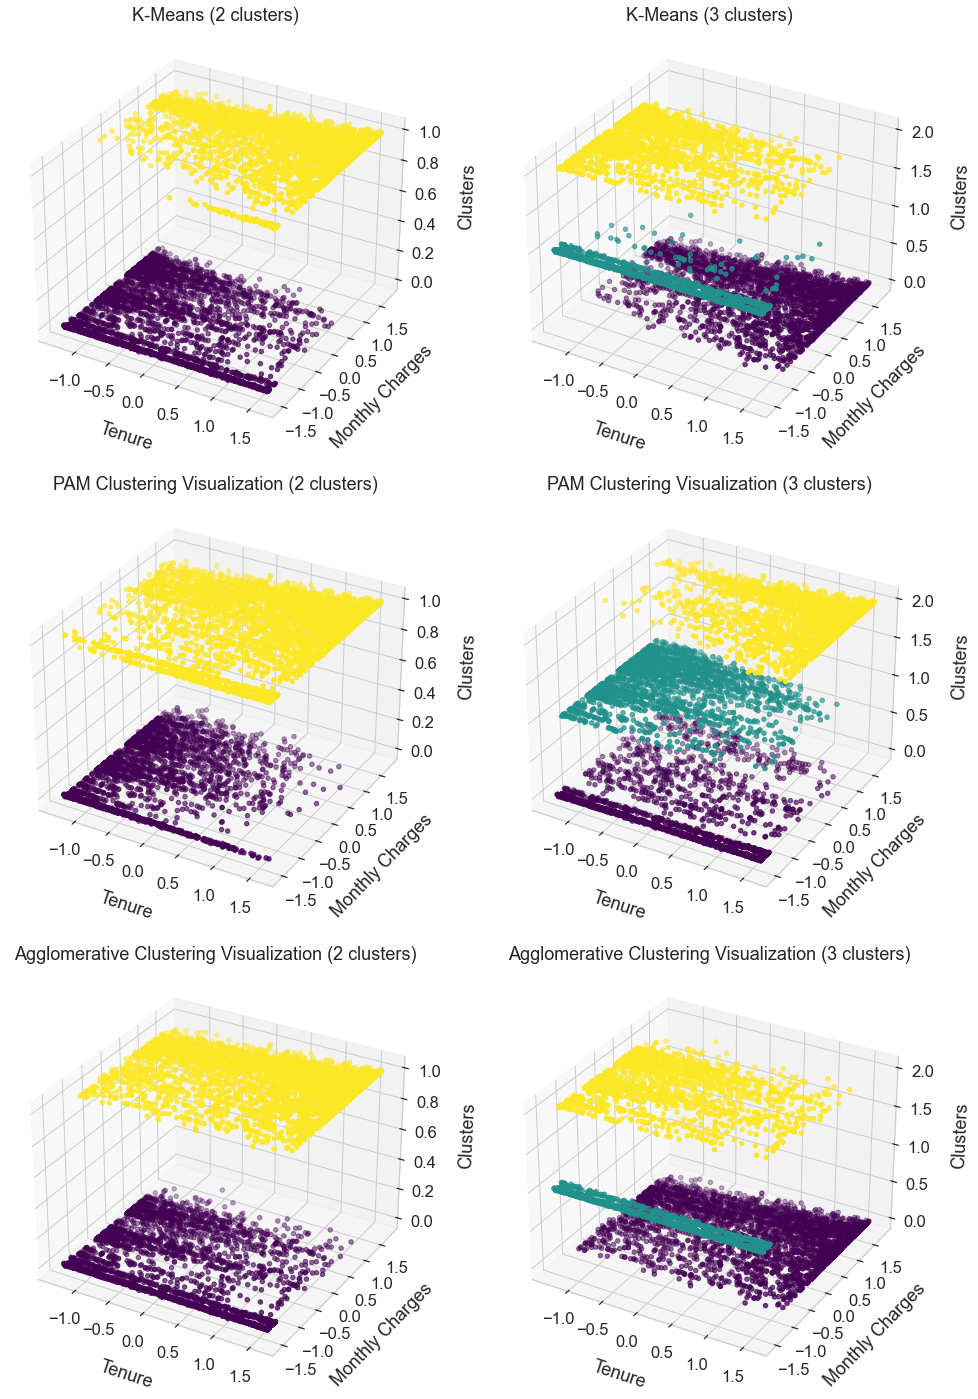

In [134]:
fig = plt.figure(figsize=(15, 20))
plt.rcParams.update({"font.size": 30})
sns.set_style("whitegrid")
# K-Means with 2 clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_cluster)

# Add subplot for K-Means (2 clusters)
ax = fig.add_subplot(3, 2, 1, projection="3d")
ax.scatter(
    df_cluster["tenure"],
    df_cluster["MonthlyCharges"],
    kmeans.labels_,
    c=kmeans.labels_,
    cmap="viridis",
)
ax.set_xlabel("Tenure", labelpad=20)
ax.set_ylabel("Monthly Charges", labelpad=20)
ax.set_zlabel("Clusters", labelpad=20)
ax.set_title("K-Means (2 clusters)")

# K-Means with 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_cluster)

# Add subplot for K-Means (3 clusters)
ax = fig.add_subplot(3, 2, 2, projection="3d")
ax.scatter(
    df_cluster["tenure"],
    df_cluster["MonthlyCharges"],
    kmeans.labels_,
    c=kmeans.labels_,
    cmap="viridis",
)
ax.set_xlabel("Tenure", labelpad=20)
ax.set_ylabel("Monthly Charges", labelpad=20)
ax.set_zlabel("Clusters", labelpad=20)
ax.set_title("K-Means (3 clusters)")

# PAM with 2 clusters
PAM = KMedoids(n_clusters=2)
PAM.fit(df_cluster)

# Add subplot for PAM (2 clusters)
ax = fig.add_subplot(3, 2, 3, projection="3d")
ax.scatter(
    df_cluster["tenure"],
    df_cluster["MonthlyCharges"],
    PAM.labels_,
    c=PAM.labels_,
    cmap="viridis",
)
ax.set_xlabel("Tenure", labelpad=20)
ax.set_ylabel("Monthly Charges", labelpad=20)
ax.set_zlabel("Clusters", labelpad=20)
ax.set_title("PAM Clustering Visualization (2 clusters)")

# PAM with 3 clusters
PAM = KMedoids(n_clusters=3)
PAM.fit(df_cluster)

# Add subplot for PAM (3 clusters)
ax = fig.add_subplot(3, 2, 4, projection="3d")
ax.scatter(
    df_cluster["tenure"],
    df_cluster["MonthlyCharges"],
    PAM.labels_,
    c=PAM.labels_,
    cmap="viridis",
)
ax.set_xlabel("Tenure", labelpad=20)
ax.set_ylabel("Monthly Charges", labelpad=20)
ax.set_zlabel("Clusters", labelpad=20)
ax.set_title("PAM Clustering Visualization (3 clusters)")

# Agglomerative with 2 clusters
agg = AgglomerativeClustering(n_clusters=2)
agg.fit(df_cluster)

# Add subplot for Agglomerative (2 clusters)
ax = fig.add_subplot(3, 2, 5, projection="3d")
ax.scatter(
    df_cluster["tenure"],
    df_cluster["MonthlyCharges"],
    agg.labels_,
    c=agg.labels_,
    cmap="viridis",
)
ax.set_xlabel("Tenure", labelpad=20)
ax.set_ylabel("Monthly Charges", labelpad=20)
ax.set_zlabel("Clusters", labelpad=20)
ax.set_title("Agglomerative Clustering Visualization (2 clusters)")

# Agglomerative with 3 clusters
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(df_cluster)

# Add subplot for Agglomerative (3 clusters)
ax = fig.add_subplot(3, 2, 6, projection="3d")
ax.scatter(
    df_cluster["tenure"],
    df_cluster["MonthlyCharges"],
    agg.labels_,
    c=agg.labels_,
    cmap="viridis",
)
ax.set_xlabel("Tenure", labelpad=20)
ax.set_ylabel("Monthly Charges", labelpad=20)
ax.set_zlabel("Clusters", labelpad=20)
ax.set_title("Agglomerative Clustering Visualization (3 clusters)")
plt.tight_layout()
plt.savefig("images_clustering/clustering_visualization_3d.pdf")